[View in Colaboratory](https://colab.research.google.com/github/vijayk2000/Text_classifier_pytorch/blob/master/Simple_text_classifier_Pytorch.ipynb)

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import os
import pandas as pd

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
listed = drive.ListFile({'q': "title contains 'data.zip' and '1cVWSXk-Swjfyx86Km8IciaDqHsJbEOBk' in parents"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))
  


title data.zip, id 1MQw3SfWZpFL-LhUjdSQ7nGklXMPly1bq


In [0]:
download_path = os.path.expanduser('/data')
try:
  os.makedirs(download_path)
except FileExistsError:
  pass

output_file = os.path.join(download_path, 'data.zip')

temp_file = drive.CreateFile({'id': '1MQw3SfWZpFL-LhUjdSQ7nGklXMPly1bq'})
temp_file.GetContentFile(output_file)

In [4]:
cd /data

/data


In [5]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


Source: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

This code is about recognizing the language.  Each file contains one name per line.  Since we need to remove diacritics, we are converting unicode string to ASCII

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def FindFiles(path): return glob.glob(path)


In [7]:
!pwd

/data


In [8]:
print(FindFiles('data/names/*.txt'))

['data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Greek.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Scottish.txt', 'data/names/Portuguese.txt', 'data/names/Spanish.txt', 'data/names/Dutch.txt', 'data/names/French.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Vietnamese.txt', 'data/names/Japanese.txt', 'data/names/Russian.txt', 'data/names/German.txt', 'data/names/Polish.txt']


In [0]:
import unicodedata
import string

In [0]:
all_letters=string.ascii_letters + ".,;"

In [11]:
print(all_letters)
n_letters=len(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;


In [12]:
print(n_letters)

55


In [0]:
def unicodetoAscii(s):
  return ''.join(
  c for c in unicodedata.normalize('NFD', s)
  if unicodedata.category(c)!='Mn'
  and c in all_letters
  )

In [14]:
print(unicodetoAscii('Ślusàrski'))

Slusarski


In [0]:
category_lines={}
all_categories=[]

def readLines(filename):
  lines=open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodetoAscii(line) for line in lines]

for filename in FindFiles('data/names/*.txt'):
  category=os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines=readLines(filename)
  category_lines[category]=lines
  

In [0]:
n_categories=len(all_categories)

In [17]:
print(category_lines['Arabic'][:5])

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']


In [18]:
!pip install torch

    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x585fe000 @  0x7f05122a82a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


Turning names into Tensors

In [0]:
import torch

#Names will have to be converted into Tensors.  To do this, we need to create it using one-hot encoding

def letterToIndex(letter):
  return all_letters.find(letter)   #'all_letters' gives the indexes of alphabets


In [0]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def lettertoTensor(letter):
  tensor=torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)]=1
  return tensor

In [0]:
def linetoTensor(line):
  tensor=torch.zeros(len(line), 1, n_letters) #To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

                                              #That extra 1 dimension is because PyTorch assumes everything is in batches -
                                              #we’re just using a batch size of 1 here.
  
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)]=1
  return tensor 

In [22]:
print(linetoTensor('jones').size())

torch.Size([5, 1, 55])


Creating the nn network

In [0]:
import torch.nn as nn

In [0]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    
    self.hidden_size=hidden_size
    self.i2h=nn.Linear(input_size+hidden_size, hidden_size)
    self.i2o=nn.Linear(input_size+hidden_size, output_size)
    self.softmax=nn.LogSoftmax(dim=1)
    
  def forward(self, input, hidden):
    combined=torch.cat((input, hidden),1)
    hidden=self.i2h(combined)
    output=self.i2o(combined)
    output=self.softmax(output)
    return output, hidden
  
  def initHidden(self):
    return torch.zeros(1, self.hidden_size)
  
n_hidden=128
rnn=RNN(n_letters, n_hidden, n_categories)

  
  
  

In [25]:
input=linetoTensor('abdul')
hidden=torch.zeros(1, n_hidden)
output, next_hidden=rnn(input[0], hidden)
print(output)

tensor([[-2.9798, -2.9093, -2.8761, -2.9012, -2.9174, -2.9116, -2.9773, -2.9116,
         -2.9152, -2.8947, -2.8174, -2.9514, -2.8168, -2.8084, -2.8590, -2.8840,
         -2.8322, -2.8854]], grad_fn=<LogSoftmaxBackward>)


From the above code, it picks the topmost likelihood of each category

In [26]:
def categoryFromOutput(output):
  top_n, top_i=output.topk(1)
  category_i=top_i[0].item()
  return all_categories[category_i], category_i   #returns the topmost category

print(categoryFromOutput(output))
  

('Vietnamese', 13)


A quick way to produce a training example

In [27]:
import random


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = linetoTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Orritt
category = Greek / line = Eliopoulos
category = Italian / line = Abrami
category = Chinese / line = See
category = Portuguese / line = Moreno
category = Scottish / line = Hill
category = French / line = Blanchett
category = Polish / line = Rusnak
category = Korean / line = Yun
category = German / line = Wegner


In [0]:
criterion=nn.NLLLoss()

In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [30]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.1081 Chu / Korean ✗ (Vietnamese)
10000 10% (0m 12s) 3.0640 Mata / Japanese ✗ (Portuguese)
15000 15% (0m 19s) 1.4106 Roosevelt / Dutch ✓
20000 20% (0m 25s) 3.0445 Peary / Portuguese ✗ (Czech)
25000 25% (0m 32s) 1.3049 Ra / Korean ✓
30000 30% (0m 38s) 1.8196 Jeong / Korean ✓
35000 35% (0m 45s) 0.3506 Ozaki / Japanese ✓
40000 40% (0m 51s) 1.2388 Avana / Spanish ✓
45000 45% (0m 58s) 2.2800 Anscombe / French ✗ (English)
50000 50% (1m 4s) 0.2766 Hwang / Korean ✓
55000 55% (1m 11s) 1.2022 Moon / Korean ✓
60000 60% (1m 17s) 0.6780 Buonarroti / Italian ✓
65000 65% (1m 23s) 0.0916 Kazuyoshi / Japanese ✓
70000 70% (1m 30s) 2.7241 Bonfils / Portuguese ✗ (French)
75000 75% (1m 36s) 2.5471 Fakhoury / English ✗ (Arabic)
80000 80% (1m 43s) 2.1690 Gray / Portuguese ✗ (Scottish)
85000 85% (1m 49s) 1.3877 Dagher / Arabic ✓
90000 90% (1m 56s) 0.2140 Ying / Chinese ✓
95000 95% (2m 2s) 0.6735 Schnur / German ✓
100000 100% (2m 9s) 0.1266 OLoughlin / Irish ✓


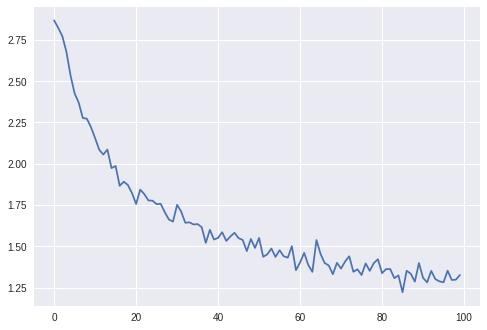

In [31]:


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)



We will create a confusion matrix to determine the accuracy for different categories

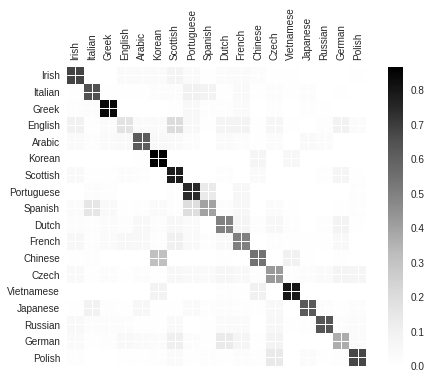

In [41]:
confusion=torch.zeros(n_categories, n_categories)
n_confusion=10000

def evaluate(line_tensor):
  hidden=rnn.initHidden()
  
  for i in range(line_tensor.size()[0]):
    output, hidden=rnn(line_tensor[i], hidden)
    
  return output

for i in range(n_confusion):
  category, line, category_tensor, line_tensor=randomTrainingExample()
  output=evaluate(line_tensor)
  guess, guess_i=categoryFromOutput(output)
  category_i=all_categories.index(category)
  confusion[category_i][guess_i]+=1
  
for i in range(n_categories):
  confusion[i]=confusion[i]/confusion[i].sum()
  
fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()




In [0]:
fig.colorbar?

Predicting on user input

In [0]:
def predict(input_line, n_predictions=3):
  print('\n> %s' % input_line)
  with torch.no_grad():
        output = evaluate(linetoTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
  

In [57]:
predict('vijay')


> vijay
(-0.64) Czech
(-2.24) English
(-2.29) Russian
